# Using VGG16 to detect diseased leaves

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
start = dt.datetime.now()

## Load numpy arrays from npz files 

In [2]:
# Load npz file containing image arrays
proc_data_labs = np.load("./proc_data.npz")
x = proc_data_labs['data']

# Load binary encoded labels for Lung Infiltrations: 0=Not diseased leaf region 1=Diseased leaf
y = proc_data_labs['labels']

## Split the data into training and validation sets. 

In [3]:
from sklearn.model_selection import train_test_split

# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.1, random_state=1, stratify=y)

In [4]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)

(1031, 256, 256, 3)
(115, 256, 256, 3)


## Instantiate VGG16

In [5]:
# Import the VGG16 network architecture
from keras.applications import VGG16;

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
BATCH_SIZE = 16

# Instantiate the model with the pre-trained weights (no top)
conv_base = VGG16(weights='./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))

# Show the architecture
conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

### Extract features underlying features from image arrays

The pre-trained models are used to extract the features so that it can be used for further feature extraction/classification

In [6]:
import os

if not os.path.exists("train_features.npz"):
    # Extract features
    train_features = conv_base.predict(np.array(X_train), batch_size=BATCH_SIZE, verbose=1)
    val_features = conv_base.predict(np.array(X_val), batch_size=BATCH_SIZE, verbose=1)

    # Save extracted features
    np.savez("train_features", train_features, y_train)
    np.savez("val_features", val_features, y_val)
else:
    train_features = np.load("train_features.npz")["arr_0"]
    val_features = np.load("val_features.npz")["arr_0"]

In [7]:
# Current shape of features
print(train_features.shape, "\n",  val_features.shape)

(1031, 8, 8, 512) 
 (115, 8, 8, 512)


### Setting labels as numerical valuse for CNN

In [8]:
labs = list(set(y))
print('Length of labs: ', len(labs))

convbin = lambda x:[1 if i == x else 0 for i in range(len(labs))]

num_labs_train = np.asarray([convbin(labs.index(i)) for i in y_train])

num_labs_val = np.asarray([convbin(labs.index(i)) for i in y_val])

Length of labs:  2


In [9]:
print(num_labs_train[0:10])
print(y_train[0:10])
print(num_labs_train.shape)
print(num_labs_val.shape)

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]
[1 0 1 1 0 0 1 0 0 1]
(1031, 2)
(115, 2)


### Classification using Random Forest on extracted features

In [115]:
from sklearn.ensemble import RandomForestClassifier

tr = train_features.reshape(train_features.shape[0], -1)
clf = RandomForestClassifier(max_depth=10, n_estimators=100)

print(tr.shape)
clf.fit(tr, y_train)

(1031, 32768)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
val = val_features.reshape(val_features.shape[0], -1)

clf.score(val, y_val)

1.0

## Classification using neural network

In [145]:
import tensorflow as tf

labs = list(set(y))

alt_num_labs_train = np.asarray([labs.index(i) for i in y_train])

alt_num_labs_val = np.asarray([labs.index(i) for i in y_val])

model_adm = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(7, activation=tf.nn.softmax)
])

adm = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)

model_adm.compile(optimizer=adm,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_adm.fit(train_features, alt_num_labs_train, epochs=1)
model_adm.evaluate(val_features, alt_num_labs_val)

Epoch 1/1
115/115 [==============================] - 0s 1ms/step


[7.152555099310121e-07, 1.0]

### Flatten extracted features

In [13]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (train_features.shape[0], 8*8*512))
val_features_flat = np.reshape(val_features, (val_features.shape[0], 8*8*512))

## Classification using CNN with the fully convoluted layers trained on images

In [14]:
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks

In [15]:
import tensorflow as tf

# Define the densely connected classifier
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 50

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(8*8*512)))
model.add(layers.Dense(2, activation=tf.nn.softmax))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-4),
    metrics=['acc'])

reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/home/sreejith/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
# Train the the model
history = model.fit(
    train_features_flat,
    num_labs_train,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, num_labs_val),
    callbacks=callbacks
)

Train on 1031 samples, validate on 115 samples
Epoch 1/50
1031/1031 [==============================] - 5s 5ms/step - loss: 0.2662 - acc: 0.9738 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 2/50
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1171e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 3/50
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1121e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 4/50
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1067e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 5/50
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1055e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 6/50
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1033e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000

Epoch 00006: ReduceLRO

## Plot the loss and accuracies 

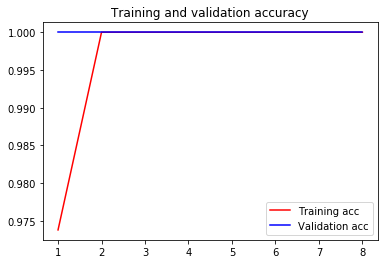

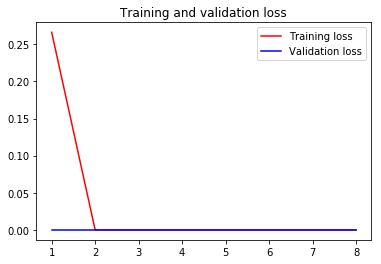

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

### check the run-time

In [146]:
# Run time
end = dt.datetime.now()
print("Run time:", (end - start).seconds, 'seconds')

Run time: 4258 seconds


## Test on single image

In [179]:
data = np.load("../test_data.npz")["arr_0"]
data.shape

feats = conv_base.predict(data)
cnn_pred = model.predict(feats.reshape(feats.shape[0], -1))
print("\nCNN predictions:\n", cnn_pred)
cnn_pred_labs = [0 if (max(pred) == pred[0]) else 1 for pred in cnn_pred]

cnn_pred_adm = model_adm.predict(feats)
print("\n\nCNN predictions:\n", cnn_pred_adm)
cnn_pred_adm_labs = [0 if (max(pred) == pred[0]) else 1 for pred in cnn_pred_adm]

rf_pred = clf.predict(feats.reshape(feats.shape[0], -1))
print("\n\nRandom Forest Prediction:\n", rf_pred)


CNN predictions:
 [[4.2423680e-01 4.7897600e-05 1.5446117e-08 4.4165630e-04 2.0723996e-01
  1.8767905e-01 1.8035470e-01]
 [2.7046670e-07 9.6692753e-01 4.1883924e-10 1.3936407e-05 3.3054240e-02
  2.7326018e-06 1.2765948e-06]
 [3.0111814e-06 9.9053651e-01 1.7330710e-13 8.6525083e-03 4.0958059e-04
  1.8870584e-05 3.7936139e-04]
 [3.9865923e-01 2.7589124e-01 6.2392237e-14 7.4798363e-09 7.9011669e-10
  3.2006967e-01 5.3798649e-03]
 [3.0033107e-08 3.1747222e-06 1.2265767e-07 1.1542363e-01 1.7051034e-04
  3.5883531e-05 8.8436669e-01]
 [1.7112972e-04 2.2198894e-05 1.2984209e-13 1.2087719e-06 2.6266264e-06
  9.9980289e-01 2.2051328e-08]
 [5.3985198e-03 1.3521332e-02 3.3582342e-08 2.1666430e-01 1.4022909e-03
  5.4984933e-01 2.1316415e-01]
 [4.7586225e-05 3.8033712e-01 1.8414872e-05 1.3741283e-01 3.4453720e-01
  1.3302366e-01 4.6232999e-03]
 [4.4553231e-06 9.9929667e-01 3.4696962e-10 1.1782319e-06 5.4770848e-04
  1.8185919e-08 1.4995039e-04]
 [9.1519300e-03 9.8528731e-01 2.6913846e-10 2.7200045e

In [180]:
rf_pred = np.array(rf_pred)
inds = np.where(rf_pred == 0)
data_non = data[inds]

In [181]:
inds

(array([ 5,  6, 10]),)

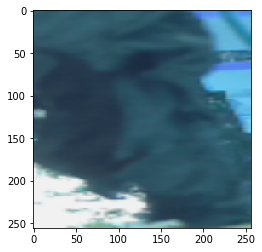

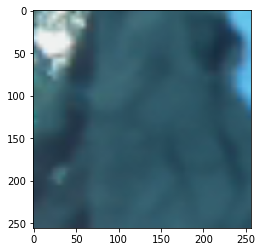

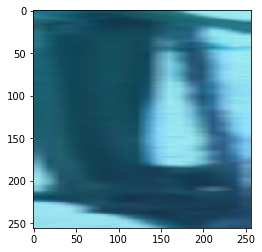

In [182]:
for img in data_non:
    plt.imshow(img)
    plt.show()

In [183]:
cnn_pred_labs = np.array(cnn_pred_labs)
inds = np.where(cnn_pred_labs == 0)
data_non = data[inds]

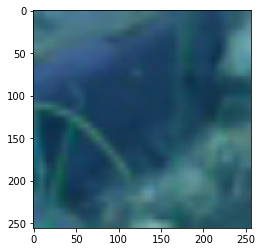

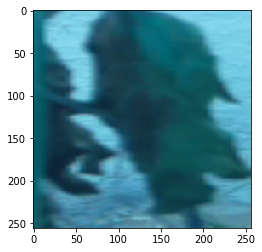

In [184]:
for img in data_non:
    plt.imshow(img)
    plt.show()

In [185]:
cnn_pred_adm_labs = np.array(cnn_pred_adm_labs)
inds = np.where(cnn_pred_adm_labs == 0)
data_non = data[inds]

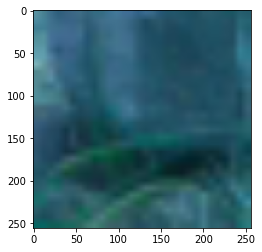

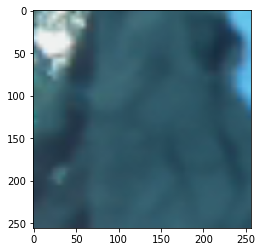

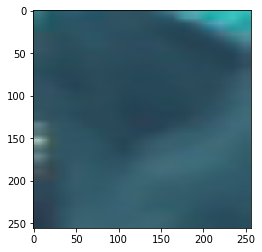

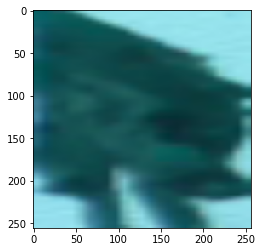

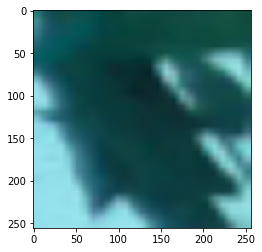

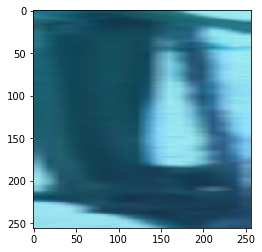

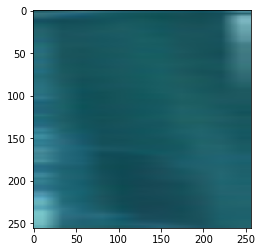

In [186]:
for img in data_non:
    plt.imshow(img)
    plt.show()

In [187]:
cnn_pred_adm_labs = np.array(cnn_pred_adm_labs)
inds = np.where(cnn_pred_adm_labs == 1)
data_dis = data[inds]

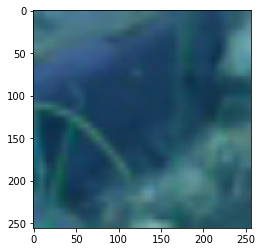

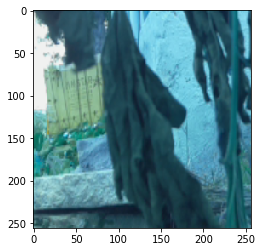

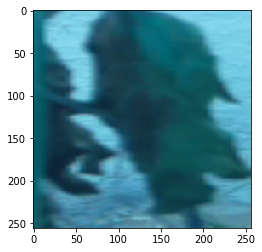

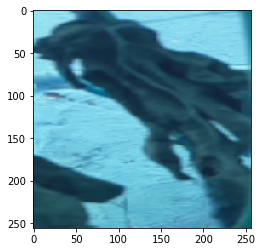

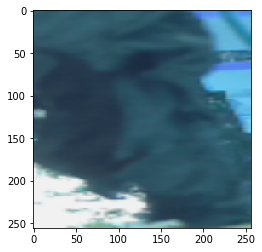

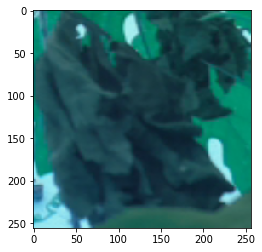

In [188]:
for img in data_dis:
    plt.imshow(img)
    plt.show()